## League of Legends Competitive Analysis
    
    by Varun Nadgir

### Using Inferential Statistics

The hypothesis I am interested in testing is whether having a lead in the early stages of a game actually leads to a victory. This lead can manifest in a few different ways, including, but not limited to, a gold lead through "creep score", gold lead through turrets taken, dragons secured, or "first bloods". Gaining a lead often times will give a team the ability to dictate the pace of the game, and so long as they continue to make the right decisions, one would think they would take the victory cleanly. However, the state of the game changes patch by patch (frequent updates released by developer Riot Games), so there are also times when an early lead needs to be absolutely monumental to make a difference and slower, defensive play is the safer option.

In [38]:
# get packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats
import math

from scipy.stats import norm

# remove assignment warning for later step
pd.options.mode.chained_assignment = None  # default='warn'

# read in csv
loldf = pd.read_csv('loldata.csv')

C:\Users\FKBOX\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
# get rows with just Team data
teams = loldf[loldf['player']=='Team']

# subset to certain columns of in-game stats
teams = teams[['gameid', 'league', 'team', 'result', 
               'teamdragkills', 'firedrakes', 'waterdrakes', 'earthdrakes', 'airdrakes', 'elders',
               'ft', 'firstmidouter', 'firsttothreetowers', 'fbaron', 'wards', 'wpm', 'visionwards', 
               'totalgold', 'goldspent', 'goldat10', 'goldat15', 'xpat10']]

# split dataset into a wins table and losses table
win_teams = teams[teams['result']==1]
lose_teams = teams[teams['result']==0]

### Some EDA

Before hopping straight into statistical analysis, we can take a look at some simple plots to see what sort of conclusions we can draw or work towards. In the plot below, I am looking at the rate at which winning and losing teams destroy structures in a game. The first tower is a very important objective which usually sets the pace for the rest of the game, thanks to a decent gold reward and the resulting map pressure it creates (the ability to roam around unseen in a larger area of the map, expanding your areas of control). 

As we can see, there is a very clear difference in these data. The winning team will almost always have the upper hand when it comes to breaking turrets. The reason 'firsttower' is closer than the others is because the first tower can sometimes be traded for by the other team and can be played around. However, once a team gets three turrets ('firsttothree'), it is a much steeper climb for the other team to try and reclaim map pressure and ultimately win (though it can happen if games are close and competitive). The question this raises, though, is whether these objectives are largely contributing to the win or if teams are able to claim these objectives because they are already winning. League of Legends games can snowball very quickly if there is a clear difference in team skill or in the tiers of Champions selected, so we need to see how large of a contribution things like 'gold', 'xp', and 'dragons taken' are making.

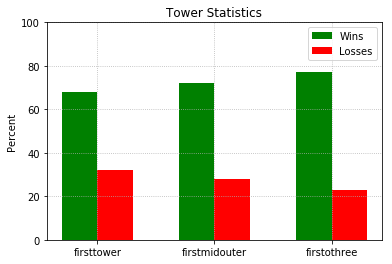

In [7]:
# take a look at tower stats
tower_stats = ['ft', 'firstmidouter', 'firsttothreetowers']

# get means for the three columns
tower_data_w = round(np.mean(win_teams[tower_stats])*100, 2)
tower_data_l = round(np.mean(lose_teams[tower_stats])*100, 2)

# create plot
_, ax = plt.subplots()
plt.bar(tower_stats, tower_data_w, color='green', width=-0.3, align='edge')
plt.bar(tower_stats, tower_data_l, color='red', width=0.3, align='edge')

# label axes and plot elements
plt.title('Tower Statistics')
plt.ylim((0,100))
plt.ylabel('Percent')
plt.legend(('Wins', 'Losses'))
plt.xticks(np.arange(3), ('firsttower', 'firstmidouter', 'firstothree'))
ax.grid(linestyle='dotted')

plt.show()

### Statistical Approach

Since we have two populations (wins and losses), we should use a two-sample test to determine whether or not there is a significant difference between the two. This would be done on a column-by-column basis, which means we would do a two-sample t-test for just 'firsttothree', for example. We can do this across many of our available variables to see which factors of a game contribute most to a victory, and if this aligns with any of our assumptions.

For each of the variables, we will work with these as our hypotheses: 

$H_0$ = there is no significant difference between the means

$H_A$ = there is a significant difference between the means 

meaning that, if the t-score is large, we can probably accept that there is a significant difference in the means. On the other hand, if the t-score is closer to 0, there is probably no significant difference between the means.

#### Dragons Taken by Winning/Losing Team

In [49]:
# get mean/std for dragons taken in wins
drag_win_mean = np.mean(win_teams['teamdragkills']) # ~2.464
drag_win_std = np.std(win_teams['teamdragkills']) # ~1.154
drag_win_count = len(win_teams) # 1251

# get mean/std for dragons taken in losses
drag_lose_mean = np.mean(lose_teams['teamdragkills']) # ~1.075
drag_lose_std = np.std(lose_teams['teamdragkills']) # ~1.170
drag_lose_count = len(lose_teams) # 1251

# calculate t-score
numerator = drag_win_mean - drag_lose_mean
denominator = np.sqrt(((drag_win_std**2)/drag_win_count) + ((drag_lose_std**2)/drag_lose_count))
t_score = numerator/denominator

# calculate p-value
pval = scipy.stats.t.sf(np.abs(t_score), 1250)*2

print("t_score: " + str(t_score) + "\np-value: " + str(pval))

t_score: 29.88601020655289
p-value: 1.5881366105366595e-148


With a t-score of 29.886, it is pretty safe to say that there is very likely a significant differences in these means. Using some of my own existing knowledge of the game, we typically only see 3-5 dragons taken in a game, so a mean of 2.464 for winning teams and 1.075 for losing teams makes it pretty clear that one team is winning. 

Additionally, the p-value is way below the significance level of 0.05, which also supports our rejection of the null hypothesis. Using this result and some knowledge of how a standard League of Legends game goes, it seems safe to say that teams that win get more dragons. However, this raises a similar question to towers - it is hard to say whether a team won because of taking dragons, or if they were able to take dragons because they were already in the lead. Unfortunately, this may be the case with many statistics we use because so much of the game is not in raw number data, but in decision-making and other intangibles.